In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
from datetime import datetime, timedelta, date

In [ ]:
import plotly.offline as pyoff
import plotly.graph_objs as go

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Next purchase day prediction:
- data wrangling
- feature engineering
- model selection
- XGBoost hyperparameter tuning

# Data

In [ ]:
# retail_df
retail_df = pd.read_csv('data/OnlineRetail.csv', parse_dates=['InvoiceDate'], encoding='unicode_escape')
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# retail_UK_df
# retail_UK_df = retail_df.query('Country == "United Kingdom"')
retail_UK_df = retail_df.loc[retail_df['Country'] == 'United Kingdom']
retail_UK_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
print('retail_UK_df has {} rows and {} columns'.format(retail_UK_df.shape[0], retail_UK_df.shape[1]))

retail_UK_df has 495478 rows and 8 columns


# Data wrangling
- cut off date: date(2011, 9, 1)
- calculate next purchase day for training


In [ ]:
retail_UK_df['InvoiceDate'].describe()

count                  495478
unique                  21220
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:49:00
Name: InvoiceDate, dtype: object

In [ ]:
# create prev 6m dataframe: (2011, 3, 1) to (2011, 8, 31)
retail_UKprev_df = retail_UK_df.loc[(retail_UK_df['InvoiceDate'].dt.date >= date(2011, 3, 1)) & (retail_UK_df['InvoiceDate'].dt.date < date(2011, 9, 1))]
retail_UKprev_df = retail_UKprev_df.reset_index()
retail_UKprev_df.tail()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
195460,320700,C565077,23196,VINTAGE LEAF MAGNETIC NOTEPAD,-3,2011-08-31 17:31:00,1.45,17451.0,United Kingdom
195461,320701,C565077,22189,CREAM HEART CARD HOLDER,-1,2011-08-31 17:31:00,3.95,17451.0,United Kingdom
195462,320702,C565077,23239,SET OF 4 KNICK KNACK TINS POPPIES,-1,2011-08-31 17:31:00,4.15,17451.0,United Kingdom
195463,320703,C565077,23197,SKETCHBOOK MAGNETIC SHOPPING LIST,-12,2011-08-31 17:31:00,1.45,17451.0,United Kingdom
195464,320704,C565078,D,Discount,-1,2011-08-31 17:45:00,57.60,16422.0,United Kingdom


In [ ]:
# create next 3m dataframe: (2011, 9, 1) to (2011, 11, 30)
retail_UKnext_df = retail_UK_df.loc[(retail_UK_df['InvoiceDate'].dt.date >= date(2011, 9, 1)) & (retail_UK_df['InvoiceDate'].dt.date < date(2011, 12, 1))]
retail_UKnext_df = retail_UKnext_df.reset_index()
retail_UKnext_df.tail()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
178689,516379,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,0.85,15676.0,United Kingdom
178690,516380,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,3.29,15676.0,United Kingdom
178691,516381,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,1.25,16717.0,United Kingdom
178692,516382,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,7.95,16717.0,United Kingdom
178693,516383,C579887,23490,T-LIGHT HOLDER HANGING LOVE BIRD,-3,2011-11-30 17:42:00,3.75,16717.0,United Kingdom


**retail_UKprev_df** represents the 6 months performance whereas we will use **retail_UKnext_df** for finding out the days between the last purchase date in retail_UKprev_df and the first one in retail_UKnext_df

In [ ]:
# create user_UK_df
user_UK_df = pd.DataFrame(retail_UKprev_df['CustomerID'].unique())
user_UK_df.columns = ['CustomerID']
user_UK_df.head()

,CustomerID
0,14620.0
1,14740.0
2,13880.0
3,16462.0
4,17068.0


In [ ]:
print('user_UK_df has {} rows'.format(user_UK_df.shape[0]))

user_UK_df has 2569 rows


In [ ]:
# missing values check
user_UK_df.isna().sum()

CustomerID    1
dtype: int64

## Calculate labels
- days between last purchase date before cut off date and first purchase date after that

In [ ]:
# create last_purchase
last_purchase = retail_UKprev_df.groupby('CustomerID')['InvoiceDate'].max()
last_purchase = last_purchase.reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']
last_purchase.head()

,CustomerID,LastPurchaseDate
0,12747.0,2011-08-22 10:38:00
1,12748.0,2011-08-30 12:00:00
2,12749.0,2011-08-18 06:19:00
3,12821.0,2011-05-09 15:51:00
4,12823.0,2011-08-04 17:45:00


In [ ]:
# create first_purchase
first_purchase = retail_UKnext_df.groupby('CustomerID')['InvoiceDate'].min()
first_purchase = first_purchase.reset_index()
first_purchase.columns = ['CustomerID', 'FirstPurchaseDate']
first_purchase.head()

,CustomerID,FirstPurchaseDate
0,12747.0,2011-10-04 08:26:00
1,12748.0,2011-09-02 10:49:00
2,12749.0,2011-11-17 12:05:00
3,12820.0,2011-09-26 11:49:00
4,12822.0,2011-09-13 13:46:00


In [ ]:
# merge last_purrchase and first_purchase
next_purchase = pd.merge(last_purchase, first_purchase, how='left', on='CustomerID')
next_purchase.head()

,CustomerID,LastPurchaseDate,FirstPurchaseDate
0,12747.0,2011-08-22 10:38:00,2011-10-04 08:26:00
1,12748.0,2011-08-30 12:00:00,2011-09-02 10:49:00
2,12749.0,2011-08-18 06:19:00,2011-11-17 12:05:00
3,12821.0,2011-05-09 15:51:00,NaT
4,12823.0,2011-08-04 17:45:00,2011-09-26 07:35:00


In [ ]:
# calculate 'NextPurchaseDate': difference between last purchase and first purchase dates
next_purchase['NextPurchaseDate'] = next_purchase['FirstPurchaseDate'] - next_purchase['LastPurchaseDate']
next_purchase['NextPurchaseDate'] = next_purchase['NextPurchaseDate'].dt.days
next_purchase.head()

,CustomerID,LastPurchaseDate,FirstPurchaseDate,NextPurchaseDate
0,12747.0,2011-08-22 10:38:00,2011-10-04 08:26:00,42.0
1,12748.0,2011-08-30 12:00:00,2011-09-02 10:49:00,2.0
2,12749.0,2011-08-18 06:19:00,2011-11-17 12:05:00,91.0
3,12821.0,2011-05-09 15:51:00,NaT,NaN
4,12823.0,2011-08-04 17:45:00,2011-09-26 07:35:00,52.0


In [ ]:
# merge with user_UK_df
user_UK_df = pd.merge(user_UK_df, next_purchase[['CustomerID', 'NextPurchaseDate']], how='left', on='CustomerID')
user_UK_df.head()

,CustomerID,NextPurchaseDate
0,14620.0,NaN
1,14740.0,NaN
2,13880.0,57.0
3,16462.0,111.0
4,17068.0,16.0


In [ ]:
# missing values check
user_UK_df.isna().sum()

CustomerID             1
NextPurchaseDate    1020
dtype: int64

We have missing values becase those customers have not made any purchase yet => we will fill missing values with 999 to quickly identify them later

In [ ]:
# fill mising values with 999
user_UK_df = user_UK_df.fillna(value=999)

In [ ]:
# describe 'NextPurchaseDate'
user_UK_df['NextPurchaseDate'].describe()

count    2569.000000
mean      449.314519
std       448.326721
min         0.000000
25%        65.000000
50%       146.000000
75%       999.000000
max       999.000000
Name: NextPurchaseDate, dtype: float64

# Feature engineering
- RFM scores
- differeces between (last purchase date and) last 3 previous purchases
- mean and std of difference between purchases
- encoding categorical features

## Recency

In [ ]:
# create last_purchase_date
last_purchase_date = retail_UKprev_df.groupby('CustomerID')['InvoiceDate'].max()
last_purchase_date = last_purchase_date.reset_index()
last_purchase_date.head()

,CustomerID,InvoiceDate
0,12747.0,2011-08-22 10:38:00
1,12748.0,2011-08-30 12:00:00
2,12749.0,2011-08-18 06:19:00
3,12821.0,2011-05-09 15:51:00
4,12823.0,2011-08-04 17:45:00


In [ ]:
# calculate recency
## recency: number of inactive days
last_purchase_date['Recency'] = last_purchase_date['InvoiceDate'].max() - last_purchase_date['InvoiceDate']
last_purchase_date['Recency'] = last_purchase_date['Recency'].dt.days
last_purchase_date.head()

,CustomerID,InvoiceDate,Recency
0,12747.0,2011-08-22 10:38:00,9
1,12748.0,2011-08-30 12:00:00,1
2,12749.0,2011-08-18 06:19:00,13
3,12821.0,2011-05-09 15:51:00,114
4,12823.0,2011-08-04 17:45:00,27


In [ ]:
# merge with user_UK_df
user_UK_df = pd.merge(user_UK_df, last_purchase_date[['CustomerID', 'Recency']], on='CustomerID')
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency
0,14620.0,999.0,104
1,14740.0,999.0,91
2,13880.0,57.0,45
3,16462.0,111.0,85
4,17068.0,16.0,10


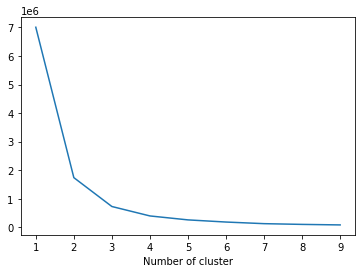

In [ ]:
# indentify number of clusters
## Elbow method
from sklearn.cluster import KMeans

cluster = user_UK_df[['Recency']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster)
    sse[i] = kmeans.inertia_ # sum of squared distances of samples to closest cluster center

## plot: n_clusters=4
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_UK_df[['Recency']])

user_UK_df['RecencyCluster'] = kmeans.predict(user_UK_df[['Recency']])
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster
0,14620.0,999.0,104,2
1,14740.0,999.0,91,2
2,13880.0,57.0,45,3
3,16462.0,111.0,85,2
4,17068.0,16.0,10,1


In [ ]:
# function for ordering cluster numbers
## ascending: True in case the higher target value, the higher score
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={'index': cluster_field_name})

    return df_final

In [ ]:
# get clusters ordered
user_UK_df = order_cluster('RecencyCluster', 'Recency', user_UK_df, ascending=False)
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster
0,14620.0,999.0,104,1
1,14740.0,999.0,91,1
2,16462.0,111.0,85,1
3,15676.0,178.0,113,1
4,15092.0,999.0,115,1


In [ ]:
# cluster profile
user_UK_df.groupby(['RecencyCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,449.0,154.665924,15.863669,126.0,141.0,154.0,167.0,183.0
1,573.0,97.125654,13.976688,75.0,85.0,98.0,110.0,125.0
2,665.0,50.935338,12.413812,33.0,40.0,49.0,62.0,73.0
3,881.0,14.049943,8.883066,0.0,7.0,13.0,21.0,31.0


## Frequency

In [ ]:
# calculate frequency
## frequency: total number of orders
frequency = retail_UKprev_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index() # create dataframe
frequency.columns = ['CustomerID', 'Frequency'] # rename columns
frequency.head()

,CustomerID,Frequency
0,12747.0,50
1,12748.0,1210
2,12749.0,160
3,12821.0,6
4,12823.0,2


In [ ]:
# merge with user_UK_df
user_UK_df = pd.merge(user_UK_df, frequency, on='CustomerID')
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency
0,14620.0,999.0,104,1,30
1,14740.0,999.0,91,1,93
2,16462.0,111.0,85,1,2
3,15676.0,178.0,113,1,63
4,15092.0,999.0,115,1,26


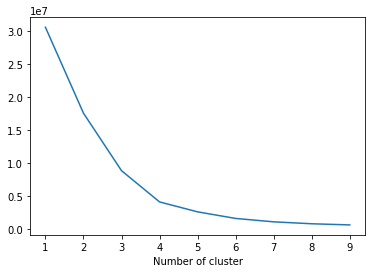

In [ ]:
# indentify number of clusters
## Elbow method
from sklearn.cluster import KMeans

cluster = user_UK_df[['Frequency']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster)
    sse[i] = kmeans.inertia_ # sum of squared distances of samples to closest cluster center

## plot: n_clusters=4
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_UK_df[['Frequency']])

user_UK_df['FrequencyCluster'] = kmeans.predict(user_UK_df[['Frequency']])
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster
0,14620.0,999.0,104,1,30,0
1,14740.0,999.0,91,1,93,0
2,16462.0,111.0,85,1,2,0
3,15676.0,178.0,113,1,63,0
4,15092.0,999.0,115,1,26,0


In [ ]:
# get clusters ordered
user_UK_df = order_cluster('FrequencyCluster', 'Frequency', user_UK_df, ascending=True)
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster
0,14620.0,999.0,104,1,30,0
1,14740.0,999.0,91,1,93,0
2,16462.0,111.0,85,1,2,0
3,15676.0,178.0,113,1,63,0
4,15092.0,999.0,115,1,26,0


In [ ]:
# cluster profile
user_UK_df.groupby(['FrequencyCluster'])['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2239.0,31.732023,26.036899,1.0,11.00,23.0,46.00,107.0
1,312.0,182.439103,70.488211,108.0,130.00,160.0,212.25,450.0
2,16.0,766.062500,260.797103,510.0,555.75,646.5,936.50,1251.0
3,1.0,3546.000000,NaN,3546.0,3546.00,3546.0,3546.00,3546.0


## Revenue

In [ ]:
# create 'Revenue' for retail_UKprev_df
retail_UKprev_df['Revenue'] = retail_UKprev_df['UnitPrice'] * retail_UKprev_df['Quantity']
retail_UKprev_df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,105335,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,15.90
1,105336,545220,48194,DOORMAT HEARTS,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,15.90
2,105337,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01 08:30:00,1.65,14620.0,United Kingdom,19.80
3,105338,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01 08:30:00,4.95,14620.0,United Kingdom,14.85
4,105339,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01 08:30:00,3.75,14620.0,United Kingdom,15.00


In [ ]:
# calculate revenue
## revenue: total revenue
revenue = retail_UKprev_df.groupby('CustomerID')['Revenue'].sum()
revenue = revenue.reset_index()
revenue.head()

,CustomerID,Revenue
0,12747.0,1760.09
1,12748.0,8115.68
2,12749.0,2532.55
3,12821.0,92.72
4,12823.0,688.50


In [ ]:
# merge with user_UK_df
user_UK_df = pd.merge(user_UK_df, revenue, on='CustomerID')
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,14620.0,999.0,104,1,30,0,393.28
1,14740.0,999.0,91,1,93,0,1423.21
2,16462.0,111.0,85,1,2,0,68.00
3,15676.0,178.0,113,1,63,0,877.40
4,15092.0,999.0,115,1,26,0,457.81


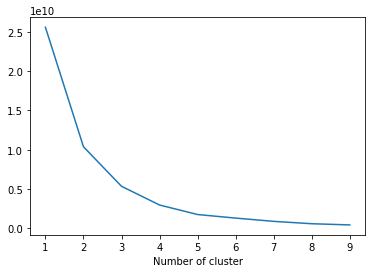

In [ ]:
# indentify number of clusters
## Elbow method
from sklearn.cluster import KMeans

cluster = user_UK_df[['Revenue']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster)
    sse[i] = kmeans.inertia_ # sum of squared distances of samples to closest cluster center

## plot: n_clusters=4
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_UK_df[['Revenue']])

user_UK_df['RevenueCluster'] = kmeans.predict(user_UK_df[['Revenue']])
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,999.0,104,1,30,0,393.28,0
1,14740.0,999.0,91,1,93,0,1423.21,0
2,16462.0,111.0,85,1,2,0,68.00,0
3,15676.0,178.0,113,1,63,0,877.40,0
4,15092.0,999.0,115,1,26,0,457.81,0


In [ ]:
# get clusters ordered
user_UK_df = order_cluster('RevenueCluster', 'Revenue', user_UK_df, ascending=True)
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,999.0,104,1,30,0,393.28,0
1,14740.0,999.0,91,1,93,0,1423.21,0
2,16462.0,111.0,85,1,2,0,68.00,0
3,15676.0,178.0,113,1,63,0,877.40,0
4,15092.0,999.0,115,1,26,0,457.81,0


In [ ]:
# cluster profile
user_UK_df.groupby(['RevenueCluster'])['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2415.0,635.360862,618.311128,-4287.63,212.1850,406.480,866.6600,2906.31
1,136.0,5237.716699,2617.500448,2952.40,3282.0950,4419.950,5634.9350,13760.87
2,15.0,24656.247333,7716.951663,15847.56,17484.2400,23196.350,31386.6450,37934.22
3,2.0,76665.615000,17370.382136,64382.90,70524.2575,76665.615,82806.9725,88948.33


## Overall score

In [ ]:
# calculate overall score
user_UK_df['OverallScore'] = user_UK_df['RecencyCluster'] + user_UK_df['FrequencyCluster'] + user_UK_df['RevenueCluster']
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,14620.0,999.0,104,1,30,0,393.28,0,1
1,14740.0,999.0,91,1,93,0,1423.21,0,1
2,16462.0,111.0,85,1,2,0,68.00,0,1
3,15676.0,178.0,113,1,63,0,877.40,0,1
4,15092.0,999.0,115,1,26,0,457.81,0,1


In [ ]:
# segmentation
user_UK_df['Segment'] = 'Low-Value'
user_UK_df.loc[user_UK_df['OverallScore'] >= 3, 'Segment'] = 'Mid-Value'
user_UK_df.loc[user_UK_df['OverallScore'] >= 5, 'Segment'] = 'High-Value'
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,999.0,104,1,30,0,393.28,0,1,Low-Value
1,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value
2,16462.0,111.0,85,1,2,0,68.00,0,1,Low-Value
3,15676.0,178.0,113,1,63,0,877.40,0,1,Low-Value
4,15092.0,999.0,115,1,26,0,457.81,0,1,Low-Value


In [ ]:
user_UK_df['Segment'].value_counts()

Low-Value     1605
Mid-Value      865
High-Value      98
Name: Segment, dtype: int64

In [ ]:
# user profile
user_UK_df.groupby('Segment')[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
Segment,,,
High-Value,9.704082,325.816327,9839.737755
Low-Value,96.566978,28.978193,451.764873
Mid-Value,17.811561,75.528324,1249.160660


## Days between (last purchase date and) last 3 purchases
- create a dataframe with 'CustomerID' and 'InvoiceDay'
- sort by 'CustomerID' and 'InvoiceDay'
- remove duplicates

In [ ]:
# create day_order
day_order = retail_UKprev_df[['CustomerID', 'InvoiceDate']]
day_order.head()

,CustomerID,InvoiceDate
0,14620.0,2011-03-01 08:30:00
1,14620.0,2011-03-01 08:30:00
2,14620.0,2011-03-01 08:30:00
3,14620.0,2011-03-01 08:30:00
4,14620.0,2011-03-01 08:30:00


In [ ]:
# 'InvoiceDay': convert 'InvoiceDate' to day
day_order['InvoiceDay'] = day_order['InvoiceDate'].dt.date
day_order.head()

,CustomerID,InvoiceDate,InvoiceDay
0,14620.0,2011-03-01 08:30:00,2011-03-01
1,14620.0,2011-03-01 08:30:00,2011-03-01
2,14620.0,2011-03-01 08:30:00,2011-03-01
3,14620.0,2011-03-01 08:30:00,2011-03-01
4,14620.0,2011-03-01 08:30:00,2011-03-01


In [ ]:
# sort by 'CustomerID' and 'InvoiceDay'
day_order = day_order.sort_values(by=['CustomerID', 'InvoiceDay'])
day_order.head()

,CustomerID,InvoiceDate,InvoiceDay
649,12747.0,2011-03-01 14:53:00,2011-03-01
650,12747.0,2011-03-01 14:53:00,2011-03-01
651,12747.0,2011-03-01 14:53:00,2011-03-01
652,12747.0,2011-03-01 14:53:00,2011-03-01
653,12747.0,2011-03-01 14:53:00,2011-03-01


We will remove the duplicates since customers can do multiple purchases in a day and difference will become 0 for those 

In [ ]:
# remove duplicates
day_order = day_order.drop_duplicates(subset=['CustomerID', 'InvoiceDay'], keep='first')
day_order.head()

,CustomerID,InvoiceDate,InvoiceDay
649,12747.0,2011-03-01 14:53:00,2011-03-01
65091,12747.0,2011-05-05 15:31:00,2011-05-05
90473,12747.0,2011-05-25 09:57:00,2011-05-25
124699,12747.0,2011-06-28 10:06:00,2011-06-28
184410,12747.0,2011-08-22 10:38:00,2011-08-22


In [ ]:
# create 3 columns with the dates of last 3 purchases: 3 lags
day_order['PrevInvoiceDay'] = day_order.groupby('CustomerID')['InvoiceDay'].shift(periods=1)
day_order['T2InvoiceDay'] = day_order.groupby('CustomerID')['InvoiceDay'].shift(periods=2)
day_order['T3InvoiceDay'] = day_order.groupby('CustomerID')['InvoiceDay'].shift(periods=3)
day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDay,T2InvoiceDay,T3InvoiceDay
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05


In [ ]:
# calculate differences
day_order['DayDiff'] = (day_order['InvoiceDay'] - day_order['PrevInvoiceDay']).dt.days
day_order['DayDiff2'] = (day_order['InvoiceDay'] - day_order['T2InvoiceDay']).dt.days
day_order['DayDiff3'] = (day_order['InvoiceDay'] - day_order['T3InvoiceDay']).dt.days
day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDay,T2InvoiceDay,T3InvoiceDay,DayDiff,DayDiff2,DayDiff3
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN,65.0,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN,20.0,85.0,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01,34.0,54.0,119.0
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0


**We only keep customers who have > 3 purchases**: it is too early to tag a customer as *frequent* who has only 2 purchases
- remove duplicates
- remove missing values

In [ ]:
# remove duplicates
## drop_duplicates: keep='last'
day_order_last = day_order.drop_duplicates(subset=['CustomerID'], keep='last')
day_order_last.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDay,T2InvoiceDay,T3InvoiceDay,DayDiff,DayDiff2,DayDiff3
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
192527,12748.0,2011-08-30 12:00:00,2011-08-30,2011-08-25,2011-08-24,2011-08-17,5.0,6.0,13.0
181411,12749.0,2011-08-18 06:19:00,2011-08-18,2011-08-11,2011-08-01,2011-05-23,7.0,17.0,87.0
70339,12821.0,2011-05-09 15:51:00,2011-05-09,NaN,NaN,NaN,NaN,NaN,NaN
169417,12823.0,2011-08-04 17:45:00,2011-08-04,2011-03-30,NaN,NaN,127.0,NaN,NaN


In [ ]:
## missing values check
day_order_last.isna().sum()

CustomerID           1
InvoiceDate          0
InvoiceDay           0
PrevInvoiceDay    1072
T2InvoiceDay      1641
T3InvoiceDay      1946
DayDiff           1072
DayDiff2          1641
DayDiff3          1946
dtype: int64

In [ ]:
# remove missing values
day_order_last = day_order_last.dropna()
day_order_last.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDay,T2InvoiceDay,T3InvoiceDay,DayDiff,DayDiff2,DayDiff3
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
192527,12748.0,2011-08-30 12:00:00,2011-08-30,2011-08-25,2011-08-24,2011-08-17,5.0,6.0,13.0
181411,12749.0,2011-08-18 06:19:00,2011-08-18,2011-08-11,2011-08-01,2011-05-23,7.0,17.0,87.0
162086,12830.0,2011-07-28 17:17:00,2011-07-28,2011-07-21,2011-07-06,2011-06-21,7.0,22.0,37.0
181480,12839.0,2011-08-18 10:01:00,2011-08-18,2011-07-29,2011-07-05,2011-06-09,20.0,44.0,70.0


## Mean and Std of difference between purchases

In [ ]:
# calculate mean and std of difference between purchases ('DayDiff')
## using day_order (not day_order_last)
day_diff = day_order.groupby('CustomerID').agg({'DayDiff': ['mean', 'std']}).reset_index()
day_diff.columns = ['CustomerID', 'DayDiffMean', 'DayDiffStd']
day_diff.head()

,CustomerID,DayDiffMean,DayDiffStd
0,12747.0,43.500000,20.305993
1,12748.0,3.723404,3.083632
2,12749.0,25.000000,30.099834
3,12821.0,NaN,NaN
4,12823.0,127.000000,NaN


In [ ]:
# merge with day_order_last
day_order_last = pd.merge(day_order_last, day_diff, how='left', on='CustomerID')
day_order_last.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDay,T2InvoiceDay,T3InvoiceDay,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0,43.500000,20.305993
1,12748.0,2011-08-30 12:00:00,2011-08-30,2011-08-25,2011-08-24,2011-08-17,5.0,6.0,13.0,3.723404,3.083632
2,12749.0,2011-08-18 06:19:00,2011-08-18,2011-08-11,2011-08-01,2011-05-23,7.0,17.0,87.0,25.000000,30.099834
3,12830.0,2011-07-28 17:17:00,2011-07-28,2011-07-21,2011-07-06,2011-06-21,7.0,22.0,37.0,12.333333,4.618802
4,12839.0,2011-08-18 10:01:00,2011-08-18,2011-07-29,2011-07-05,2011-06-09,20.0,44.0,70.0,32.800000,26.166773


In [ ]:
# merge with user_UK_df
user_UK_df = pd.merge(user_UK_df, day_order_last[['CustomerID', 'DayDiff', 'DayDiff2', 'DayDiff3', 'DayDiffMean', 'DayDiffStd']], how='left', on='CustomerID')
user_UK_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,14620.0,999.0,104,1,30,0,393.28,0,1,Low-Value,NaN,NaN,NaN,NaN,NaN
1,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value,6.0,34.0,92.0,30.666667,26.102363
2,16462.0,111.0,85,1,2,0,68.00,0,1,Low-Value,NaN,NaN,NaN,NaN,NaN
3,15676.0,178.0,113,1,63,0,877.40,0,1,Low-Value,NaN,NaN,NaN,NaN,NaN
4,15092.0,999.0,115,1,26,0,457.81,0,1,Low-Value,NaN,NaN,NaN,NaN,NaN


## Encoding categorical features

In [ ]:
# create data_df
data_df = user_UK_df.copy()

In [ ]:
# remove missing values: only keep customers who have >3 purchases
data_df = data_df.dropna()

In [ ]:
# onehot encoding: pd.get_dummies
data_df = pd.get_dummies(data=data_df)
data_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
1,14740.0,999.0,91,1,93,0,1423.21,0,1,6.0,34.0,92.0,30.666667,26.102363,0,1,0
8,17770.0,999.0,98,1,38,0,1143.27,0,1,14.0,77.0,84.0,28.000000,30.512293,0,1,0
9,15643.0,999.0,79,1,36,0,647.40,0,1,5.0,6.0,12.0,25.750000,43.553607,0,1,0
11,14231.0,999.0,79,1,35,0,513.11,0,1,4.0,53.0,103.0,34.333333,26.274195,0,1,0
15,18218.0,999.0,106,1,24,0,626.38,0,1,5.0,61.0,75.0,25.000000,27.221315,0,1,0


In [ ]:
print('data_df has {} rows and {} columns'.format(data_df.shape[0], data_df.shape[1]))

data_df has 623 rows and 17 columns


# Model selection
- indentify classes of label ('NextPurchaseDate'): using percentiles
- check the correlation between features and label
- train and test split
- crossvalidate models


In [ ]:
# describe 'NextPurchaseDate'
data_df['NextPurchaseDate'].describe()

count    623.000000
mean     176.390048
std      326.482713
min        0.000000
25%       24.500000
50%       47.000000
75%       87.000000
max      999.000000
Name: NextPurchaseDate, dtype: float64

We will have 3 classes:
- class 2 for customers that will purchase in 0-19 days
- class 1 for customers that will purchase in 20-49 days
- class 0 for customers that will purchase more than 50 days

In [ ]:
# identify classes: 3 classes
data_df['NextPurchaseDayRange'] = 2
data_df.loc[data_df['NextPurchaseDate'] >= 20, 'NextPurchaseDayRange'] = 1
data_df.loc[data_df['NextPurchaseDate'] >= 50, 'NextPurchaseDayRange'] = 0
data_df.head()

,CustomerID,NextPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
1,14740.0,999.0,91,1,93,0,1423.21,0,1,6.0,34.0,92.0,30.666667,26.102363,0,1,0,0
8,17770.0,999.0,98,1,38,0,1143.27,0,1,14.0,77.0,84.0,28.000000,30.512293,0,1,0,0
9,15643.0,999.0,79,1,36,0,647.40,0,1,5.0,6.0,12.0,25.750000,43.553607,0,1,0,0
11,14231.0,999.0,79,1,35,0,513.11,0,1,4.0,53.0,103.0,34.333333,26.274195,0,1,0,0
15,18218.0,999.0,106,1,24,0,626.38,0,1,5.0,61.0,75.0,25.000000,27.221315,0,1,0,0


In [ ]:
# calculate correlation
corr = data_df.corr()
corr['NextPurchaseDayRange'].sort_values(ascending=False)

NextPurchaseDayRange    1.000000
OverallScore            0.520286
RecencyCluster          0.484566
Segment_High-Value      0.339363
RevenueCluster          0.322785
FrequencyCluster        0.280423
Revenue                 0.250712
Frequency               0.249464
Segment_Mid-Value       0.128040
CustomerID              0.041635
DayDiff                -0.176051
DayDiff2               -0.241452
DayDiff3               -0.259525
DayDiffMean            -0.268880
DayDiffStd             -0.272527
NextPurchaseDate       -0.437262
Segment_Low-Value      -0.446097
Recency                -0.540997
Name: NextPurchaseDayRange, dtype: float64

'OverallScore' has the highest positive correlation (0.52) and 'Recency' has the highest negative correlation (-0.54)

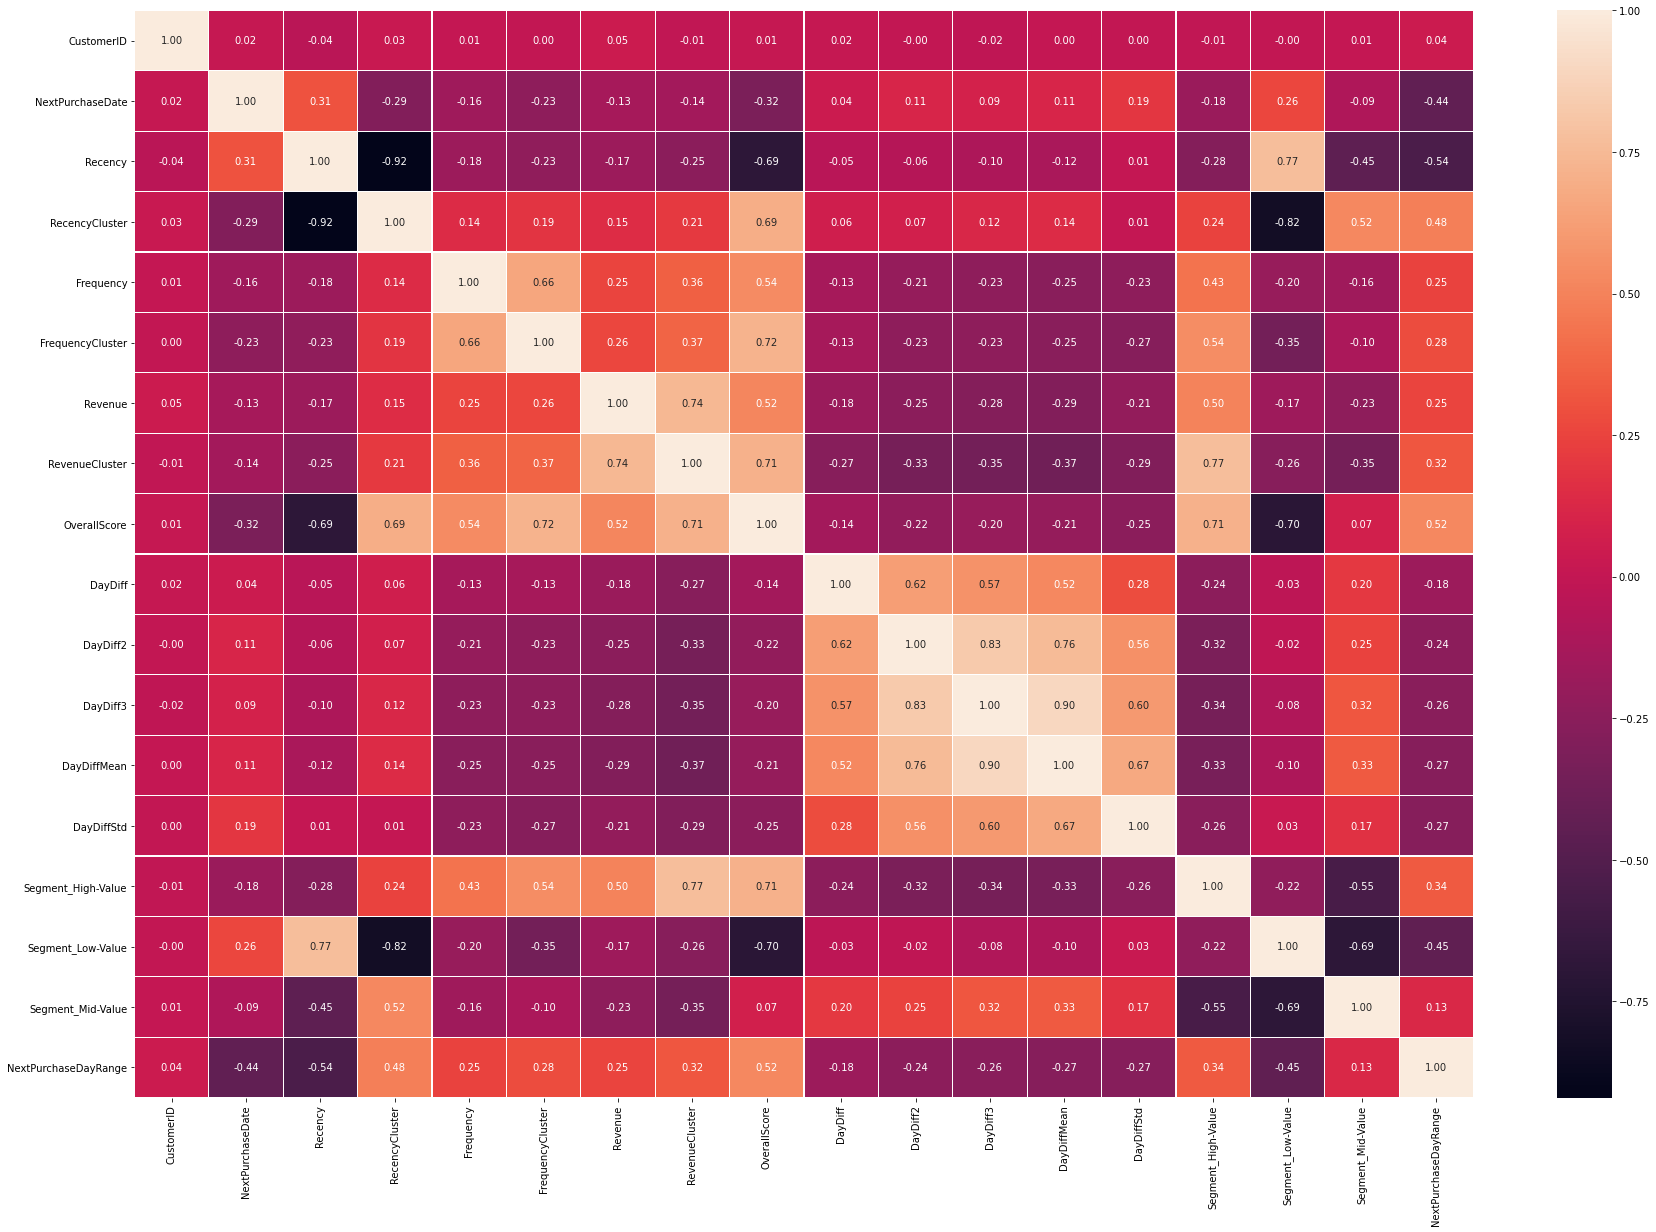

In [ ]:
# plot correlation: sns.heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(corr, annot=True, linewidths=0.2, fmt='.2f')
plt.show()

In [ ]:
# create feature set and label
X = data_df.drop(['NextPurchaseDate', 'NextPurchaseDayRange'], axis=1)
y = data_df['NextPurchaseDayRange']

In [ ]:
# train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train.shape

(560, 16)

In [ ]:
X_test.shape

(63, 16)

## Crossvalidate models

In [ ]:
# create list of models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

models = []
models.append(('k nearest neighbors:', KNeighborsClassifier()))
models.append(('logistic regression:', LogisticRegression()))
models.append(('support vector classifier:', SVC()))
models.append(('naive bayes:', GaussianNB()))
models.append(('decision tree:', DecisionTreeClassifier()))
models.append(('random forest:', RandomForestClassifier()))
models.append(('gradient boosting classifier:', GradientBoostingClassifier()))
models.append(('xgboost:', xgb.XGBClassifier()))

In [ ]:
# crossvalidate models
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

for name, model in models:
    kfold = KFold(n_splits=2, random_state=42)
    cv_result = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
    print(name, cv_result)

k nearest neighbors: [0.53214286 0.46428571]
logistic regression: [0.58571429 0.58571429]
support vector classifier: [0.55       0.47857143]
naive bayes: [0.6        0.58214286]
decision tree: [0.575      0.58214286]
random forest: [0.61428571 0.58571429]
gradient boosting classifier: [0.60357143 0.56428571]
xgboost: [0.56071429 0.575     ]


# XGBoost
- tuning using sklearn GridSearchCV
- params: max_depth, min_child_weight

In [ ]:
# build xgb_model
import xgboost as xgb

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# accuracy
print('accuracy of XGBClassifier on training set: {}'.format(xgb_model.score(X_train, y_train)))
print('accuracy of XGBClassifier on test set: {}'.format(xgb_model.score(X_test, y_test)))

accuracy of XGBClassifier on training set: 0.9125
accuracy of XGBClassifier on test set: 0.6190476190476191


In [ ]:
# y_pred
y_pred = xgb_model.predict(X_test)

In [ ]:
# classification_report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.73      0.67        26
           1       0.55      0.55      0.55        22
           2       0.80      0.53      0.64        15

    accuracy                           0.62        63
   macro avg       0.65      0.60      0.62        63
weighted avg       0.63      0.62      0.62        63



## Tuning

In [ ]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}

gsearch = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    iid=False,
    cv=2
)

gsearch.fit(X_train, y_train)

print(gsearch.best_params_)
print(gsearch.best_score_)

{'max_depth': 7, 'min_child_weight': 1}
0.5964285714285715


In [ ]:
# build xgb_model
xgb_model = xgb.XGBClassifier(max_depth=7, min_child_weight=1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# accuracy
print('accuracy of XGBClassifier on training set: {}'.format(xgb_model.score(X_train, y_train)))
print('accuracy of XGBClassifier on test set: {}'.format(xgb_model.score(X_test, y_test)))

accuracy of XGBClassifier on training set: 1.0
accuracy of XGBClassifier on test set: 0.6507936507936508


In [ ]:
# y_pred
y_pred = xgb_model.predict(X_test)

In [ ]:
# classification_report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.73      0.69        26
           1       0.61      0.64      0.62        22
           2       0.73      0.53      0.62        15

    accuracy                           0.65        63
   macro avg       0.66      0.63      0.64        63
weighted avg       0.66      0.65      0.65        63

